### We will discuss transfer learning in this session. 
#### Also we will work with feature extraction to see transfer learning in action.

In [1]:
import keras

In [2]:
from keras.applications.vgg16 import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
!unzip /content/train.zip
!unzip /content/validation.zip
!unzip /content/test.zip

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [6]:
datagenerator = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagenerator.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [8]:
test_features, test_labels = extract_features('/content/test', 1000)
train_features, train_labels = extract_features('/content/train', 2000)
validation_features, validation_labels = extract_features('/content/validation', 1000)

Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [32]:
print(validation_features.shape)
print(validation_labels.shape)

(1000, 4, 4, 512)
(1000,)


In [47]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [48]:
from keras import models
from keras import layers
from keras import optimizers

In [49]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [50]:
from tensorflow.keras import optimizers

In [51]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [52]:
print(train_features.shape)
print(train_labels.shape)

(2000, 8192)
(2000,)


In [53]:
memoryM = model.fit(train_features, 
                    train_labels, 
                    epochs = 30, 
                    batch_size = 20, validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 6ms/step - loss: 0.6084 - acc: 0.6575 - val_loss: 0.4329 - val_acc: 0.8510
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4140 - acc: 0.8130 - val_loss: 0.3603 - val_acc: 0.8600
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3460 - acc: 0.8540 - val_loss: 0.3209 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3047 - acc: 0.8760 - val_loss: 0.2918 - val_acc: 0.8820
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2859 - acc: 0.8905 - val_loss: 0.2822 - val_acc: 0.8930
Epoch 6/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2665 - acc: 0.8935 - val_loss: 0.2695 - val_acc: 0.8910
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2464 - acc: 0.8995 - val_loss: 0.2643 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - loss: 0.

In [54]:
import matplotlib.pyplot as plt
acc = memoryM.history['acc']
val_acc = memoryM.history['val_acc']
loss = memoryM.history['loss']
val_loss = memoryM.history['val_loss']

In [55]:
epochs = range(len(acc))

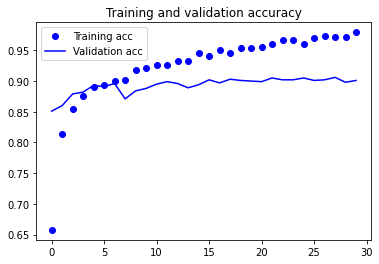

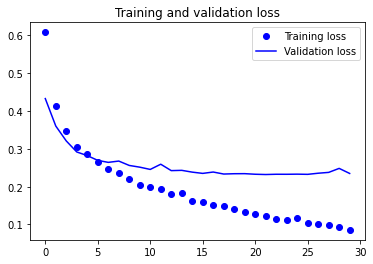

In [56]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### From now on we will use conv_base model and use its weights for our model.(Transfer Learning)

In [57]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [58]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [59]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [60]:
conv_base.trainable = False

In [61]:
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [62]:
from keras.preprocessing.image import ImageDataGenerator
train_datagenerator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [64]:
test_datagenerator = ImageDataGenerator(rescale=1./255)

In [66]:
train_generator = train_datagenerator.flow_from_directory(
        '/content/train',
        target_size = (150, 150),
        batch_size = 20,
        class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/validation',
        target_size = (150, 150),
        batch_size = 20,
        class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [67]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 2e-5), metrics = ['acc'])

In [68]:
memoryM1 = model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs = 30,
      validation_data = validation_generator,
      validation_steps = 50,
      verbose = 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
100/100 - 20s - loss: 0.5784 - acc: 0.7000 - val_loss: 0.4312 - val_acc: 0.8290 - 20s/epoch - 203ms/step
Epoch 2/30
100/100 - 19s - loss: 0.4786 - acc: 0.7870 - val_loss: 0.3664 - val_acc: 0.8340 - 19s/epoch - 190ms/step
Epoch 3/30
100/100 - 19s - loss: 0.4282 - acc: 0.8040 - val_loss: 0.3426 - val_acc: 0.8530 - 19s/epoch - 193ms/step
Epoch 4/30
100/100 - 19s - loss: 0.3978 - acc: 0.8300 - val_loss: 0.3197 - val_acc: 0.8670 - 19s/epoch - 191ms/step
Epoch 5/30
100/100 - 19s - loss: 0.3957 - acc: 0.8260 - val_loss: 0.2927 - val_acc: 0.8680 - 19s/epoch - 192ms/step
Epoch 6/30
100/100 - 19s - loss: 0.3724 - acc: 0.8330 - val_loss: 0.2857 - val_acc: 0.8720 - 19s/epoch - 193ms/step
Epoch 7/30
100/100 - 19s - loss: 0.3686 - acc: 0.8380 - val_loss: 0.2875 - val_acc: 0.8810 - 19s/epoch - 191ms/step
Epoch 8/30
100/100 - 19s - loss: 0.3558 - acc: 0.8425 - val_loss: 0.2868 - val_acc: 0.8770 - 19s/epoch - 190ms/step
Epoch 9/30
100/100 - 19s - loss: 0.3372 - acc: 0.8535 - val_loss: 0.2658

In [69]:
model.save('cats_and_dogs_small_3.h5')

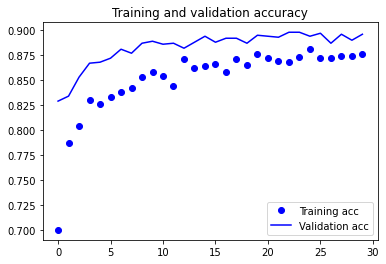

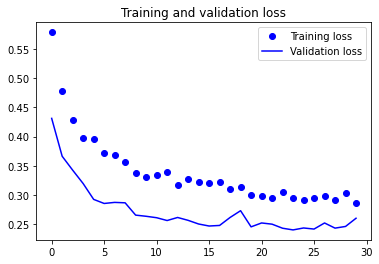

In [70]:
acc = memoryM1.history['acc']
val_acc = memoryM1.history['val_acc']
loss = memoryM1.history['loss']
val_loss = memoryM1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()